activate npx...

### Compute power spectrum density with Python multiprocessing framework

In [8]:
import scipy
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from matplotlib import pyplot as plt


def get_site_power(trace, site):
    """calculate the power spectrum of the input trace

    Args:
        traces (np.ndarray): timepoints x sites voltage trace
        sfreq (_type_): voltage trace sampling frequency

    Returns:
        _type_: _description_
    """
    sfreq = 40000  # sampling frequency
    (freq, power) = scipy.signal.periodogram(trace, sfreq, scaling="density")
    return np.array(power), np.array(freq)


def create_test_signal(seed):
    fs = 1000.0  # 1 kHz sampling frequency
    F1 = 10  # First signal component at 10 Hz
    F2 = 60  # Second signal component at 60 Hz
    T = 10  # 10s signal length
    N0 = -10  # Noise level (dB)

    t = np.r_[0 : T : (1 / fs)]  # Sample times

    # Two Sine signal components at frequencies F1 and F2.
    signal = np.sin(2 * F1 * np.pi * t) + np.sin(2 * F2 * np.pi * t)

    # White noise with power N0
    np.random.seed(seed)
    signal += np.random.randn(len(signal)) * 10 ** (N0 / 20.0)
    return signal

test signal shape: (10000, 2)


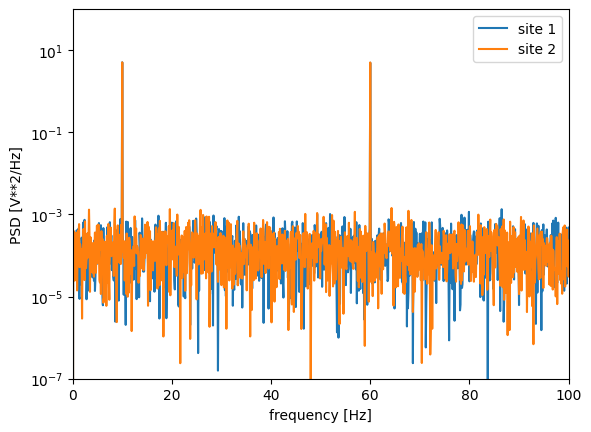

In [55]:
# create test signals
test_signal1 = create_test_signal(seed=0)
test_signal2 = create_test_signal(seed=1)

# stack as one timepoints x sites array
test_signals = np.vstack([test_signal1, test_signal2]).T
print("test signal shape:", test_signals.shape)

# compute power for each site in parallel
with ProcessPoolExecutor() as executor:
    power_by_site = executor.map(
        get_site_power,
        test_signals.T,
        np.arange(0, test_signals.shape[1], 1),
    )
power_by_sites = list(power_by_site)

# plot
freqs = power_by_sites[0][1]
signal_1 = power_by_sites[0][0][0]
signal_2 = power_by_sites[0][0][1]
plt.semilogy(freqs, signal_1, label="site 1")
plt.semilogy(freqs, signal_2, label="site 2")
plt.ylim([1e-7, 1e2])
plt.xlim([0, 100])
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.legend()
plt.show()

# references

https://stackoverflow.com/questions/71291252/how-to-pass-multiple-arguments-in-multiprocessing-executor-map-function